# Decision trees & ensemble learning


##  Pontuação de risco de crédito

Imagine que trabalhamos em um banco. Quando recebemos um pedido de empréstimo, precisamos ter certeza de que, se dermos o dinheiro, o cliente poderá pagá-lo de volta. Todo aplicativo traz um risco de inadimplência - a não devolução do dinheiro.

Gostaríamos de minimizar esse risco: antes de concordar em conceder um empréstimo, queremos pontuar o cliente e avaliar as chances de inadimplência. Se for muito alto, rejeitamos o pedido. Esse processo é chamado de “pontuação de risco de crédito”.

Usaremos aprendizado de máquina para calcular o risco de inadimplência. 

**O plano do projeto é o seguinte :**

* Primeiro, obtemos os dados e fazemos algum pré-processamento inicial.
* Em seguida, treinamos um modelo de árvore de decisão do Scikit-learn para prever a probabilidade de inadimplência.
* Em seguida, explicamos como funcionam as árvores de decisão e quais parâmetros o modelo possui e mostramos como ajustar esses parâmetros para obter o melhor desempenho.
* Em seguida, combinamos várias árvores de decisão em um modelo – uma floresta aleatória. Observamos seus parâmetros e os ajustamos para obter o melhor desempenho preditivo.
* Por fim, exploramos uma maneira diferente de combinar árvores de decisão - aumento de gradiente. Usamos o XGBoost, uma biblioteca altamente eficiente que implementa o aumento de gradiente. Vamos treinar um modelo e ajustar seus parâmetros .

A pontuação de risco de crédito é um problema de classificação binária: a meta é positiva (“1”) se o cliente inadimplir e negativa (“0”) caso contrário

In [1]:
#imports de lei 
import pandas as pd 
import numpy as np 

import seaborn as sns 
from matplotlib import pyplot as plt 
%matplotlib inline 

In [2]:
# ler os dados
df = pd.read_csv('CreditScoring.csv')

In [3]:
# visualizando as cinco primeiras linhas 
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Todas os nomes das colunas começam com letra maiúscula. vamos transformar todos em letras minúsculas. 

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


**Podemos ver que o DataFrame possui as seguintes colunas :**

* `status`: se o cliente conseguiu pagar o empréstimo (1) ou não (2)
* `seniorty`: experiência de trabalho em anos
* `home`: tipo de casa própria: aluguel (1), proprietário (2) e outros
* `time`: período planejado para o empréstimo (em meses)
* `age`: idade do cliente
* `marital` [estado]: solteiro (1), casado (2) e outros
* `records`: se o cliente possui registros anteriores: não (1), sim (2) (não está claro na descrição do conjunto de dados que tipo de registros temos nesta coluna. Para os propósitos deste projeto, podemos assumir que é sobre registros no banco de dados do banco.)
* `job`: tipo de job: full-time (1), part-time (2), e outros
* `expenses` (despesas): quanto o cliente gasta por mês
* `income` (Renda): quanto o cliente ganha por mês
* `assets` (ativos): valor total de todos os ativos do cliente
* `debt` (dívida): montante da dívida de crédito
* `amount` (montante): valor solicitado do empréstimo
* `price` (preço): preço de um item que o cliente deseja comprar

Embora a maioria das colunas seja numérica, algumas são categóricas: status, casa, estado civil, registros e trabalho. Os valores que vemos no DataFrame, no entanto, são números, não strings. Isso significa que precisamos traduzi-los para seus nomes reais.

Começamos com a coluna de status. O valor “1” significa “OK”, o valor “2” significa “padrão” e “0” significa que o valor está ausente — vamos substituí-lo por “unk” (abreviação de “desconhecido”).

In [6]:
# primeiro definimos o dicionário 
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

# Podemos usar map para converter os números em strings (atraves do dicionario criado)
df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
# cria o dicionário para a coluna home 
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

#faz o mapeamento 
df.home = df.home.map(home_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,rent,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,owner,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,rent,36,26,1,1,1,46,107,0,0,310,910


In [8]:
# fazendo o mesmo para todas as colunas restantes: 
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
 
df.marital = df.marital.map(marital_values)
 
 
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
 
df.records = df.records.map(records_values)
 
 
job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
 
df.job = df.job.map(job_values)

In [9]:
# apos as transformaçoes, as colunas com variáveis categóricas contêm valores reais, não numeros 
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


**Vejamos as variáveis numéricas:**

In [10]:
df.describe().round() # verifica as estatísticas resumidas de cada uma das colunas

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


**OBSERVAÇÃO**

A saída de `describe` pode ser confuso. No nosso caso, existem valores em notação científica como 1,000000e+08 ou 8,703625e+06. Para forçar o Pandas a usar uma notação diferente, usamos `round`: remove a parte fracionária de um número e arredonda para o inteiro mais próximo.

Vemos que em varias colunas o max é 999999999, isso indica valores ausentes. 

Identificamos 3 colunas que têm esse problema: `income`, `assets` e `debt`

Vamos substituir por `NaN`. 

In [11]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan) #substitui o valor 9999... por np.nan (NaN) usando o método replace

In [12]:
# verificando o resultado da transformação: 
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [13]:
# visualizando quantidade de NaN em cada coluna 
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

Vamos olhar nossa variável de destino (target) `status`: 

In [14]:
# retorna a contagem de cada valor: 
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

Há um registro para qual o status é `unk` (desconhecido). Vamos removê-lo.  

Não é util para nós.

In [15]:
df = df[df.status != 'unk']

### Preparação do conjunto de dados 

* Divida o conjunto de dados em treinamento, validação e teste.
* Lidar com valores ausentes.
* Use a codificação one-hot para codificar variáveis categóricas.
* Crie a matriz de recursos X e a variável de destino y 

Vamos começar dividindo os dados. Vamos dividir os dados em três partes:

* Dados de treinamento (60% do conjunto de dados original)
* Dados de validação (20%)
* Dados de teste (20%)

In [16]:
from sklearn.model_selection import train_test_split

# com train_test_split podemos dividir um dataset em apenas duas partes
# mas precisamos de três, portanto relizamos a divisão duas vezes.
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [17]:
# verificando o tamanho do nosso dataset
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

O resultado que queremos prever é status. Vamos usá-lo para treinar um modelo, então é nosso y — a variável de destino. Como nosso objetivo é determinar se alguém não paga o empréstimo, a classe positiva é default. Isso significa que y é “1” se o cliente for inadimplente e “0” caso contrário

In [18]:
# implementação 
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

In [19]:
# remover o status do dataframe, para não usar acidentalmente para treinamento
del df_train['status']
del df_val['status']

In [20]:
# substituindo valores ausentes por 0
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

**Agora cuidaremos de X — a matriz de recursos.**

**Codificação One-Hot** 

Serve para codificar as variáveis categóricas.

Cada valor é codificado como “1” se estiver presente (“hot”) ou “0” se estiver ausente (“cold”)

In [21]:
# primeiro convertemos o dataframe para lista de dicionário: 
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

Cada dicionário no resultado representa uma linha do DataFrame. Por exemplo, o primeiro registro em dict_trainse parece com isso:

`
{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}`

In [22]:
# usando a lista de dicionário como entrada para o dictVectorizer: 
from sklearn.feature_extraction import DictVectorizer
 
dv = DictVectorizer(sparse=False)
 
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

Como resultado, temos matrizes de recursos para conjuntos de dados de treinamento e validação

## Decision Trees 

Uma árvore de decisão (Decision Trees) é uma estrutura de dados que codifica uma série de regras if-then-else. Cada nó em uma árvore contém uma condição. Se a condição for satisfeita, vamos para o lado direito da árvore; caso contrário, vamos para a esquerda. No final, chegamos à decisão final.

É muito fácil representar uma árvore de decisão como um conjunto de if-elsedeclarações em Python. Por exemplo:

`def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'`

In [23]:
#import do scikit-learn para treinar uma arvore de decisão 
from sklearn.tree import DecisionTreeClassifier

In [24]:
# Treinamento o modelo: 
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Para verificar se o resultado é bom, precisamos avaliar o desempenho preditivo do modelo no conjunto de validação. Vamos usar AUC (área sob a curva ROC) para isso.

In [25]:
# import 
from sklearn.metrics import roc_auc_score

In [26]:
#Avaliando o desempenho no dataset de treinamento 
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

Quando a executamos, vemos que a pontuação é 100% – a pontuação perfeita. 

In [27]:
#verificando a pontuação na validação 
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.644359545663704

Após a execução, vemos que a AUC na validação é de apenas 65%.

Acabamos de observar um caso de `overfitting` . A árvore aprendeu os dados de treinamento tão bem que simplesmente memorizou o resultado de cada cliente. No entanto, quando o aplicamos ao conjunto de validação, o modelo falhou. 

Temos várias maneiras de controlar a complexidade de uma árvore. Uma opção é restringir seu tamanho: podemos especificar o parametro max_depth,  que controla o número máximo de níveis. Quanto mais níveis uma árvore tiver, mais regras complexas ela poderá aprender

Uma árvore com mais níveis pode aprender regras mais complexas. Uma árvore com dois níveis é menos complexa do que uma árvore com três níveis e, portanto, menos propensa ao overfitting.

In [28]:
# mudando o max_depth para 2
dt = DecisionTreeClassifier(max_depth=2) # o padrão do max_depth é None
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [29]:
# visualizando a arvore 
from sklearn.tree import export_text 
 
tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records=yes <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- class: True
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



 No final, se a classe for True, então a decisão é “default”; caso contrário, é “OK”.
 
 A condição `records=no > 0.50` significa que um cliente não tem registros. Lembre-se de que usamos a codificação one-hot para representar `records` com duas características: `records=yes` e `records=no`. Para um cliente sem registros, `records=no` está definido como “1” e `records=yes` para “0”. Por isso, " `records=no > 0.50` é verdadeiro quando o valor para `records` é `no`

In [30]:
# vamos conferir a pontuação: 
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc', auc)
 
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

train auc 0.7054989859726213
validation auc 0.6685264343319367


* Desempenho nos dados de treino caiu de 100% para 70% (ele não pode mais memorizar) 
* desempenho nos dados de validação melhorou em 3% 

**No entanto, esta árvore tem outro problema - é muito simples.**

## Ajuste de parâmetros para árvore de decisão

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [31]:
#encontrando os melhores parâmetros para max_depth
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]: # None = não há restrição de profundidade, a árvore crescerá o maximo que puder 
    dt = DecisionTreeClassifier(max_depth=depth) # cria um objeto classificador de decision tree com max_depth definida para o valor da iteração atual do loop
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.756
  10 -> 0.683
  15 -> 0.669
  20 -> 0.652
None -> 0.632


vemos que `max_depth` de 5 dá a melhor AUC (76,6%), seguido por 4 e 6

In [32]:
#iteramos sob os 3 melhores parâmetros de max_depth
for m in [4, 5, 6]: 
    print('depth: %s' % m)
    
    # encontrando os melhores parâmetros para min_leaf_size 
    for s in [1, 5, 10, 15, 20, 50, 100, 200]: 
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train) 
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    
    print()
        



depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.768
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.745
5 -> 0.760
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.772
100 -> 0.776
200 -> 0.768



Depois de executá-lo, vemos que o melhor AUC é de 78,5% com parâmetros min_sample_ leaf =15 e max_depth=6.

Como vemos, o valor que usamos para min_leaf_sizeinfluencia o melhor valor de max_depth.

In [33]:
# usando os melhores parâmetros para treinar o modelo final: 
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

As árvores de decisão são modelos simples e eficazes, mas tornam-se ainda mais poderosas quando combinamos várias árvores.

### Treinando uma random forest 

`Random forest` é um algoritmo de aprendizagem de máquina supervisionado que consiste em um conjunto de árvores de decisão. Cada árvore de decisão é treinada separadamente em um subconjunto aleatório dos dados de treinamento. Em seguida, as previsões de todas as árvores são combinadas para gerar uma predição final.

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
rf = RandomForestClassifier(n_estimators=10, random_state=3) # n_estimators é o numero de arvores que queremos ter no conjunto, random_state é a semente (serve para dar o mesmo resultado)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=3)

In [36]:
# avaliando o desempenho do resultado 
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7811145285897654

obtemos uma AUC de 78%

Vamos analisar outros valores para `n_estimators` para ver quantas arvores nós precisamos. 

In [37]:
aucs = [] # Cria uma lista com resultados AUC
 
for i in range(10, 201, 10):# Treina progressivamente mais árvores em cada iteração
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    
     # avalia o desempenho 
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
 
    # Adiciona a pontuação à lista com outras pontuações
    aucs.append(auc)

10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


Text(0, 0.5, 'AUC')

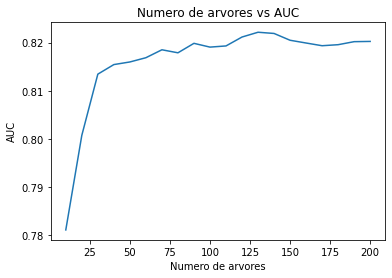

In [38]:
# plotando os resultados: 
plt.plot(range(10, 201, 10), aucs)
plt.title('Numero de arvores vs AUC')
plt.xlabel('Numero de arvores')
plt.ylabel('AUC')

Vemos que o maior desempenho foi de 82% 

O número de árvores não é o único parâmetro que podemos alterar para obter um melhor desempenho

## Ajuste de parâmetros para floresta aleatória

Um conjunto de floresta aleatória consiste em várias árvores de decisão, portanto, os parâmetros mais importantes que precisamos ajustar para a floresta aleatória são os mesmos:

`max_depth`

`min_leaf_size`

In [39]:
# max_depth
all_aucs = {} # cria um dicionário para armazenar os resultados AUC

# iteração entre diferentes valores de depth
for depth in [5, 10, 20]: 
    print('depth %s' % depth)
    aucs = [] # Cria uma lista com os resultados AUC para o nível de profundidade atual
    
    for i in range(10, 201, 10): 
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
        
    all_aucs[depth] = aucs
    print()
    

depth 5
10 -> 0.788
20 -> 0.798
30 -> 0.800
40 -> 0.800
50 -> 0.800
60 -> 0.801
70 -> 0.802
80 -> 0.803
90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

depth 10
10 -> 0.791
20 -> 0.808
30 -> 0.812
40 -> 0.818
50 -> 0.817
60 -> 0.819
70 -> 0.820
80 -> 0.820
90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

depth 20
10 -> 0.776
20 -> 0.803
30 -> 0.813
40 -> 0.817
50 -> 0.815
60 -> 0.813
70 -> 0.814
80 -> 0.815
90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



Agora para cada valor de max_depth, temos uma série de pontuações AUC. Podemos plotá-los agora:

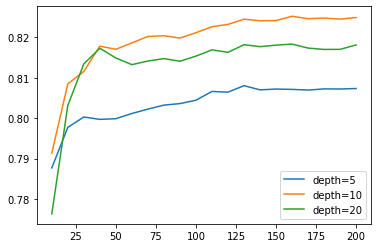

In [40]:
num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label='depth=5')
plt.plot(num_trees, all_aucs[10], label='depth=10')
plt.plot(num_trees, all_aucs[20], label='depth=20')
plt.legend()

Com max_depth=10, a AUC ultrapassa os 82%, enquanto que para outros valores tem um desempenho pior.

Agora vamos sintonizar min_samples_leaf. Definimos o valor para o parâmetro max_depth da etapa anterior e, em seguida, siga a mesma abordagem anterior para determinar o melhor valor para min_samples_leaf:

In [41]:
all_aucs = {}
 
for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
 
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
   
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.811
30 -> 0.823
50 -> 0.823
70 -> 0.822
90 -> 0.823
110 -> 0.823
130 -> 0.824
150 -> 0.825
170 -> 0.825
190 -> 0.825

min_samples_leaf: 5
10 -> 0.813
30 -> 0.818
50 -> 0.821
70 -> 0.822
90 -> 0.822
110 -> 0.825
130 -> 0.825
150 -> 0.825
170 -> 0.825
190 -> 0.826

min_samples_leaf: 10
10 -> 0.810
30 -> 0.822
50 -> 0.822
70 -> 0.819
90 -> 0.820
110 -> 0.820
130 -> 0.821
150 -> 0.820
170 -> 0.820
190 -> 0.820



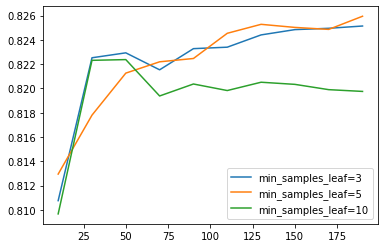

In [42]:
# Vamos plotar: 
num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()

Vemos que AUC é um pouco melhor para pequenos valores de `min_samples_leafe` o melhor valor é 5.

Assim, os melhores parâmetros de floresta aleatória para o nosso problema são

* `max_depth=10`
* `min_samples_leaf=5`

Alcançamos a melhor AUC com 200 árvores, então devemos definir o parâmetro `n_estimators` para 200

In [43]:
# treinando o modelo final: 
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)

Para tornar um conjunto útil, as árvores em uma floresta aleatória devem ser diferentes umas das outras. Isso é feito por: 

**_Selecionar aleatoriamente um subconjunto diferente de recursos para cada árvore_**


## Gradient boosting

A floresta aleatória não é a única maneira de combinar várias árvores de decisão. Há uma abordagem diferente: aumento de gradiente (gradient boosting).

Podemos treinar modelos sequencialmente – cada próximo modelo tenta corrigir os erros do anterior:

* Treine o primeiro modelo.
* Veja os erros que ele comete.
* Treine outro modelo que corrija esses erros.
* Olhe para os erros novamente; repetir sequencialmente.

Essa forma de combinar modelos é chamada de `boosting`. O `gradient boosting` é uma variação particular dessa abordagem que funciona especialmente bem com árvores

Temos muitas boas implementações do modelo de aumento de gradiente: GradientBoostingClassifierde Scikit-learn, XGBoost, LightGBM e CatBoost. Desta vez, vamos usar o XGBoost.

In [44]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [45]:
import xgboost as xgb

Antes de podermos treinar um modelo XGBoost, precisamos agrupar nossos dados em `DMatrix`—uma estrutura de dados especial para encontrar divisões de forma eficiente. 

In [46]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)

Ao criar uma instância de DMatrix, passamos três parâmetros:

* `X_train`: a matriz de recursos
* `y_train`: a variável de destino
* `feature_names`: os nomes dos recursos em X_train

Vamos fazer o mesmo para o conjunto de dados de validação:

In [47]:
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

Especificando parâmetros para treinamento
https://xgboost.readthedocs.io/en/latest/parameter.html

In [48]:
xgb_params = {
    'eta': 0.3, #learning rate 
    'max_depth': 6,# especifica a profundidade maxima de cada árvore
    'min_child_weight': 1, # Define a soma mínima do peso das instâncias necessária para criar uma nova partição em um nó folha da árvore.  Controla a complexidade do modelo, evitando particionamento de nós que têm um peso muito baixo. 
 
    'objective': 'binary:logistic', # especifica a tarefa de aprendizagem, 'binary:logistic' é usado para problemas de classificação binária, otimizando a função logística
    'nthread': 8, # Especifica o número de threads paralelas a serem usadas durante o treinamento
    'seed': 1, #  Define uma semente (seed) para garantir a reprodutibilidade dos resultados.
    'silent': 1 # Controla a verbosidade do algoritmo. Quando definido como 1, o XGBoost não imprimirá mensagens durante o treinamento.
}

In [49]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10) #num_boost_round = numero de arvores para treinar 

[14:09:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



In [50]:
# avaliando o modelo: fazer previsão nos dados de validação
y_pred = model.predict(dval)

In [51]:
# visualizando as previsões:
y_pred[:10]

array([0.08926772, 0.0468099 , 0.09692743, 0.17261842, 0.05435968,
       0.12576081, 0.08033007, 0.61870354, 0.486538  , 0.04056795],
      dtype=float32)

O resultado, `y_pred`, é uma matriz NumPy unidimensional com previsões: a pontuação de risco para cada cliente no conjunto de dados de validação

In [52]:
#calculando o auc 
roc_auc_score(y_val, y_pred)

0.8152745150274878

Depois de executá-lo, obtemos 81,5%. Este é um resultado bastante bom, mas ainda é um pouco pior do que nosso melhor modelo de random forest  (82,5%).

## Monitoramento de desempenho do modelo

Para ter uma ideia de como a AUC muda à medida que o número de árvores cresce, podemos usar uma lista de observação - um recurso integrado no XGBoost para monitorar o desempenho do modelo.

Uma watchlist é uma lista Python com tuplas. Cada tupla contém uma DMatrix e seu nome. Normalmente fazemos assim :

In [53]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [54]:
# especificando a métrica usada na lista de parâmetros: 

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc', # here, Define a métrica de avaliação para o AUC
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

Para usar a lista de observação durante o treinamento, precisamos especificar dois argumentos extras para o função train:

* `evals`: a lista de observação.
* `verbose_eval`: com que frequência imprimimos a métrica. Se definirmos como “10”, veremos o resultado após cada 10º passo.

In [56]:
# vamos treinar o xgboosta 
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

[14:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.95002	val-auc:0.81558
[20]	train-auc:0.97316	val-auc:0.81775
[30]	train-auc:0.98772	val-auc:0.81787
[40]	train-auc:0.99456	val-auc:0.81387
[50]	train-auc:0.99688	val-auc:0.81128
[60]	train-auc:0.99889	val-auc:0.80801
[70]	train-auc:0.99944	val-auc:0.80732
[80]	train-auc:0.99985	val-auc:0.80677
[90]	train-auc:0.99992	val-auc:0.80637
[99]	train-auc:0.99998	val-auc:0.80546


## Ajuste de parâmetros do xgboost 


Estamos interessados ​​principalmente nos três primeiros parâmetros. Esses parâmetros controlam o processo de treinamento:

**Taxa de Aprendizagem**

`eta`: Taxa de Aprendizagem. As árvores de decisão e a floresta aleatória não possuem esse parâmetro. Cobriremos isso mais tarde nesta seção quando o ajustarmos

No boosting, cada árvore tenta corrigir os erros das iterações anteriores. A taxa de aprendizado determina o peso dessa correção. Se tivermos um grande valor para eta, a correção supera significativamente as previsões anteriores. Por outro lado, se o valor for pequeno, apenas uma pequena fração dessa correção é utilizada.

In [57]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [58]:
# treinando o xgboosta com 500 iterações 
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

[14:36:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.91558	val-auc:0.80009
[20]	train-auc:0.93933	val-auc:0.80920
[30]	train-auc:0.95411	val-auc:0.81557
[40]	train-auc:0.96332	val-auc:0.81843
[50]	train-auc:0.97014	val-auc:0.82348
[60]	train-auc:0.97641	val-auc:0.82446
[70]	train-auc:0.98124	val-auc:0.82477
[80]	train-auc:0.98567	val-auc:0.82329
[90]	train-auc:0.98818	val-auc:0.82363
[100]	train-auc:0.99056	val-auc:0.82371
[110]	train-auc:0.99305	val-auc:0.82355
[120]	train-auc:0.99434	val-auc:0.82208
[130]	train-auc:0.99510	val-auc:0.82079
[140]	train-auc:0.99606	val-auc:0.82025
[150]	train-auc:0.99690	val-auc:0.81946
[160]	train-auc:0.99741	val-auc:0.81907
[170]	train-auc:0.99794	val-auc:0.81839
[180]	train-auc:0.99832	val-auc:0.81830
[190]	train-auc:0.99874	val-auc:0.81711
[200]	train-auc

Ao executá-lo, vemos que a melhor pontuação de validação é de 82,4%

O próximo parâmetro que ajustamos é max_depth. O valor padrão é 6, então podemos tentar

Um valor menor; por exemplo, 3
Um valor mais alto; por exemplo, 10

In [61]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

[14:42:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.77424	val-auc:0.73571
[10]	train-auc:0.84733	val-auc:0.78964
[20]	train-auc:0.86359	val-auc:0.80617
[30]	train-auc:0.87855	val-auc:0.81478
[40]	train-auc:0.88701	val-auc:0.81990
[50]	train-auc:0.89458	val-auc:0.82595
[60]	train-auc:0.90159	val-auc:0.82806
[70]	train-auc:0.90650	val-auc:0.82801
[80]	train-auc:0.91110	val-auc:0.82940
[90]	train-auc:0.91428	val-auc:0.82997
[100]	train-auc:0.91801	val-auc:0.83221
[110]	train-auc:0.92205	val-auc:0.83290
[120]	train-auc:0.92460	val-auc:0.83285
[130]	train-auc:0.92843	val-auc:0.83414
[140]	train-auc:0.93100	val-auc:0.83463
[150]	train-auc:0.93296	val-auc:0.83525
[160]	train-auc:0.93551	val-auc:0.83554
[170]	train-auc:0.93788	val-auc:0.83638
[180]	train-auc:0.93971	val-auc:0.83657
[190]	train-auc:0.94203	val-auc:0.83562
[200]	train-auc

A melhor AUC que obtemos com 3 é de 83,6%.
Em seguida, com 10. Nesse caso, o melhor valor é 81,1% .

O próximo parâmetro que ajustamos é min_child_weight. É o mesmo que min_leaf_sizenas árvores de decisão do Scikit-learn: controla o número mínimo de observações que uma árvore pode ter em uma folha.

* Para min_child_weight=1, AUC é de 83,6%.
* Para min_child_weight=10, AUC é de 83,3%.
* Para min_child_weight=30, AUC é de 83,5%.

In [63]:
# parâmetros finais do modelo: 
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=190, verbose_eval=10,
                  evals=watchlist)

[14:46:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.77424	val-auc:0.73571
[10]	train-auc:0.84733	val-auc:0.78964
[20]	train-auc:0.86359	val-auc:0.80617
[30]	train-auc:0.87855	val-auc:0.81478
[40]	train-auc:0.88701	val-auc:0.81990
[50]	train-auc:0.89458	val-auc:0.82595
[60]	train-auc:0.90159	val-auc:0.82806
[70]	train-auc:0.90650	val-auc:0.82801
[80]	train-auc:0.91110	val-auc:0.82940
[90]	train-auc:0.91428	val-auc:0.82997
[100]	train-auc:0.91801	val-auc:0.83221
[110]	train-auc:0.92205	val-auc:0.83290
[120]	train-auc:0.92460	val-auc:0.83285
[130]	train-auc:0.92843	val-auc:0.83414
[140]	train-auc:0.93100	val-auc:0.83463
[150]	train-auc:0.93296	val-auc:0.83525
[160]	train-auc:0.93551	val-auc:0.83554
[170]	train-auc:0.93788	val-auc:0.83638
[180]	train-auc:0.93971	val-auc:0.83657
[189]	train-auc:0.94177	val-auc:0.83583


O melhor que o modelo de floresta aleatória (random forest) foi capaz de obter 82,5% de AUC, enquanto o melhor que o modelo de aumento de gradiente conseguiu foi 1% a mais (83,6%) .

## Testando o modelo final

Ainda precisamos fazer duas coisas antes de podermos usá-lo:

* Retreine o modelo final em conjuntos de dados de treinamento e validação combinados. Não precisamos mais do conjunto de dados de validação, então podemos usar mais dados para treinamento, o que tornará o modelo um pouco melhor.
* Teste o modelo no conjunto de teste. Esta é a parte dos dados que mantivemos de lado desde o início. Agora, nós o usamos para garantir que o modelo não tenha superajustado e tenha um bom desempenho em dados completamente invisíveis.

Os próximos passos são:

* Aplique o mesmo pré-processamento para df_full_traine df_testcomo fizemos para df_traine df_val. Como resultado, obtemos as matrizes de atributos X_traine X_testbem como nossas variáveis ​​de destino y_traine y_test.
* Treine um modelo no conjunto de dados combinado com os parâmetros que selecionamos anteriormente.
* Aplique o modelo aos dados de teste para obter as previsões de teste.
* Verifique se o modelo tem um bom desempenho e não superajusta.

In [64]:
#criando a variavel de destino 
y_train = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values

In [65]:
# removendo a variavel de destino 
del df_train_full['status']
del df_test['status']

In [66]:
#convertemos o df em listas de dicionarios
dict_train = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

# codificação one-hot 
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

In [67]:
# treinando o modelo xgboosta 
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)
 
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
 
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}
 
num_trees = 160
 
model = xgb.train(xgb_params, dtrain, num_boost_round=num_trees)

[14:56:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



In [69]:
# avaliando o desempenho no conjunto de teste: 
y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

0.8322845901959826

A saída é de 83,2%, o que é comparável a 83,6% — o desempenho no conjunto de validação. Isso significa que nosso modelo não é superajustado (overfit)e pode funcionar bem com clientes que ainda não atendeu.